## Read, drop col & rename client_ids


In [23]:
import pandas as pd     

# * Read Csv file
dataframe = pd.read_table("./dataset/train.tsv")
dataframe = dataframe.drop(columns=["accent", "sentence"])


client_ids = dataframe.groupby(["client_id"]).sum().reset_index()["client_id"].tolist()
new_client_id = [x for x in range(len(client_ids) + 1)]

def rename_client(row):
    return client_ids.index(row["client_id"])
    
# * Rename client id
dataframe["client_id"] = dataframe.apply(rename_client, axis=1)
client_ids

['04383b5618f4d8d8ef2b075c6e24f754ac6c0795717058f7e330bcd09e1e835f3e854446fda612edf59a9159f87a4475a1fad99f520e9df05caabe23d304af28',
 '049331a0346569d9b41738e0f31f495d097afc16eb54efc5f27518208f9c7ed004bb26d5a32fd6336a425b7768ffb3ead7a5fab8507ef2329be5e77359d6cee1',
 '05dcd675ff28c44de2d0bd7030c78fb36acf063b2c4637efb8496706947a73aeeddb95018e589fc7a96fa64d5a67220492e13dfb7ffd49b4f959512f3d55328e',
 '0db436d79939c80652cff5594757cf7a702d90321a100acb25d16586cc946fcd26e099a79996b73208bcce6d6364542e0654751a15f67d46e5cc5c3acc9c1783',
 '132887d56b0a8a5fc31dda4427b695133e69d6748b660267b866a39104419cfb642bc0eb4f1a5f21f63b3286841e37e0e709cc3a4aa03aac812e0af21314ff93',
 '1653ff7efc02d8f0e0d8be05adb19e1bfca543cee27730a522095473492bc9e3651c3f827725b8d4e4c57509f58ffccd0201d1bb4afb4136b9ab45e90b7f981d',
 '1c9bb0afebfe84890b58ee511a58fc0dd5620b863d7497c57f5b9a9a42d9418ff3b7206297ffac7949e386229705eddcb3bdadebacdf117ff4525357f283d110',
 '1e848413a3350d126cf0ce308fdae55242765ba6161db0d0efeff88d99a818dd3fd

# Filtering data

In [24]:
filtered = pd.DataFrame(columns=dataframe.columns)
occurances = dataframe.groupby("client_id").size()

nb_occurence = 400
last_id = 0

for occurance in occurances.items():
    if(occurance[1] > nb_occurence):
        id = occurance[0]
        filtered = pd.concat([filtered, dataframe.query("client_id == @id")], ignore_index=True) 

grouped = filtered.groupby("client_id")
filtered = grouped.head(nb_occurence)
filtered = filtered.query("up_votes >= 2")

print("nb class:", len(grouped))


nb class: 13


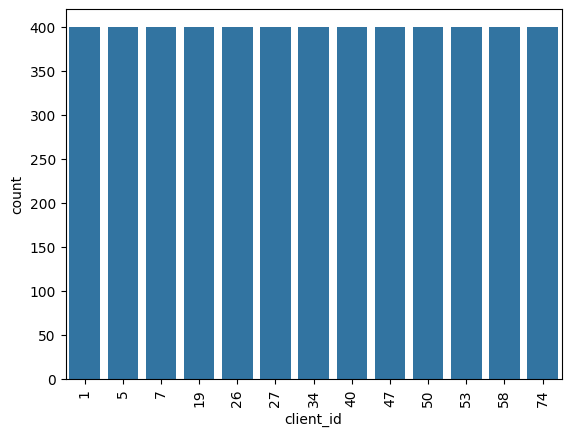

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=filtered["client_id"]) # plot the categories
plt.xticks(rotation=90);

In [26]:
filtered

,client_id,path,up_votes,down_votes,age,gender
0,1,1f0193f454471d950810b7935d712b45ae4f5ddad735a8...,2,0,fourties,male
1,1,b206709c8b8bf975dfa01ed9fadf578418a9a5670a9a77...,2,0,fourties,male
2,1,8eab9439c5fed9fe692ebfad57974203d1ae2f9aeffdab...,2,0,fourties,male
3,1,c37120ccb46cf34bb65c478ed75466b6bbf5024873a132...,2,0,fourties,male
4,1,ea4cff95f58cf1d3037149cf0b3eb461dbcc8851039a7e...,2,0,fourties,male
...,...,...,...,...,...,...
11054,74,fc8a4308cae376266377e56fa1f024c6100623afbe6ea1...,2,0,thirties,male
11055,74,fd628f61a13391c8bc5efbdcee2faea976369987421434...,2,0,thirties,male
11056,74,b0814a01281f5b82c7b3e001b8447caa1d0bfb23ad6258...,3,0,thirties,male
11057,74,4158555df75e808681747e9f83625936340e429fa9d86c...,2,0,thirties,male


# Extraction features function


In [27]:
import librosa
import numpy as np


def extract_features(audio, client_id):
    features = []
    features.append(client_id)

    chroma_stft = librosa.feature.chroma_stft(y=audio)
    features.append(np.mean(chroma_stft))
    features.append(np.var(chroma_stft))

    rms = librosa.feature.rms(y=audio)
    features.append(np.mean(rms))
    features.append(np.var(rms))

    spectral_centroids = librosa.feature.spectral_centroid(y=audio)
    features.append(np.mean(spectral_centroids))
    features.append(np.var(spectral_centroids))

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio)
    features.append(np.mean(spectral_bandwidth))
    features.append(np.var(spectral_bandwidth))

    rolloff = librosa.feature.spectral_rolloff(y=audio)
    features.append(np.mean(rolloff))
    features.append(np.var(rolloff))

    zcr = librosa.feature.zero_crossing_rate(y=audio)
    features.append(np.mean(zcr))
    features.append(np.var(zcr))

    harmony = librosa.effects.harmonic(y=audio)
    features.append(np.mean(harmony))
    features.append(np.var(harmony))

    tempo = librosa.feature.tempo(y=audio)
    features.append(tempo[0])

    mfcc = librosa.feature.mfcc(y=audio)

    # print(len(mfcc))
    for x in mfcc:
        features.append(np.mean(x))
        features.append(np.var(x))
    # print("ftlen:", len(features))
    return features

# Build feature dataframe


In [28]:

# * reset indexing of dataframe
filtered = filtered.reset_index(drop=True)
filtered = filtered.drop(columns=["up_votes", "down_votes"])
filtered

,client_id,path,age,gender
0,1,1f0193f454471d950810b7935d712b45ae4f5ddad735a8...,fourties,male
1,1,b206709c8b8bf975dfa01ed9fadf578418a9a5670a9a77...,fourties,male
2,1,8eab9439c5fed9fe692ebfad57974203d1ae2f9aeffdab...,fourties,male
3,1,c37120ccb46cf34bb65c478ed75466b6bbf5024873a132...,fourties,male
4,1,ea4cff95f58cf1d3037149cf0b3eb461dbcc8851039a7e...,fourties,male
...,...,...,...,...
5195,74,fc8a4308cae376266377e56fa1f024c6100623afbe6ea1...,thirties,male
5196,74,fd628f61a13391c8bc5efbdcee2faea976369987421434...,thirties,male
5197,74,b0814a01281f5b82c7b3e001b8447caa1d0bfb23ad6258...,thirties,male
5198,74,4158555df75e808681747e9f83625936340e429fa9d86c...,thirties,male


In [29]:
columns_audio_pipeline = [
    "client", "mfcc1_mean", "mfcc1_var", "mfcc2_mean", "mfcc2_var", "mfcc3_mean",
    "mfcc3_var", "mfcc4_mean", "mfcc4_var", "mfcc5_mean", "mfcc5_var", "mfcc6_mean", "mfcc6_var",
    "mfcc7_mean", "mfcc7_var", "mfcc8_mean", "mfcc8_var", "mfcc9_mean", "mfcc9_var",
    "mfcc10_mean", "mfcc10_var", "mfcc11_mean", "mfcc11_var", "mfcc12_mean", "mfcc12_var",
    "mfcc13_mean", "mfcc13_var", "mfcc14_mean", "mfcc14_var", "mfcc15_mean", "mfcc15_var",
    "mfcc16_mean", "mfcc16_var", "mfcc17_mean", "mfcc17_var", "mfcc18_mean", "mfcc18_var",
    "mfcc19_mean", "mfcc19_var", "mfcc20_mean", "mfcc20_var", "chroma_stft_mean", "chroma_stft_var",
    "rms_mean",  "rms_var", "spectral_centroids_mean", "spectral_centroids_var", "spectral_bandwidth_mean", "spectral_bandwidth_var",
    "rolloff_mean",  "rolloff_var",  "zcr_mean",  "zcr_var",  "harmony_mean", "harmony_var",
    "tempo",
]

features_df = pd.DataFrame(columns=columns_audio_pipeline)

index = 0
for i in range(len(filtered)):
    row = filtered.loc[i]
    print("client:", row["client_id"])
    # * Build audio clip path
    clips_path = "./dataset/data/clips/"
    audio_file = clips_path + row.path + ".mp3"
    
    # * Load audio
    audio, sr = librosa.load(audio_file)
    
    # * read feature from audio pist
    features = extract_features(audio,  row["client_id"])
    # * append audio feature to the feature dataframe
    features_df.loc[index] = features
    index += 1

features_df['client'] = features_df['client'].astype(str).apply(lambda x: x.replace('.0',''))

features_df.to_csv("./dataset/train/fitlered_segemented_" + str(nb_occurence)  + ".csv", index=False)

client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1
client: 1


In [60]:
features_df.to_csv("./dataset/train/fitlered_segemented_200.csv", index=False)

# Train & Teste split
 

In [385]:
from sklearn.model_selection import train_test_split
import pandas as pd
# ! Can read the saved CSV
features_df = pd.read_csv("./dataset/train/fitlered_segemented_300.csv")

grouped = features_df.groupby("client")
print("nombre de classe:", len(grouped))

labels = features_df['client']
labels_ = [x for x in set(labels)]
print("labels", labels_)

features = features_df.drop('client', axis = 1)

x = np.array(features, dtype = float)
y = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)

unique_labels = list(set(labels_))
len(unique_labels)

x_train.shape, y_train.shape, x_test.shape,  y_test.shape

nombre de classe: 16
labels [0, 1, 34, 58, 5, 7, 40, 74, 11, 47, 50, 19, 53, 24, 26, 27]


((4560, 55), (4560,), (240, 55), (240,))

In [386]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

encoder = LabelEncoder()
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
y_train = encoder.fit_transform(y_train)

x_test = scaler.fit_transform(x_test)
y_test = encoder.fit_transform(y_test)

x.shape, y.shape

((4800, 55), (4800,))

# Model build


In [387]:
from tensorflow import keras
from keras.optimizers import Adam
import tensorflow as tf

keras.utils.set_random_seed(812)
tf.config.experimental.enable_op_determinism()

# build model
model = keras.models.Sequential([
    keras.layers.Dense(64, activation = 'relu', input_shape = (x_train.shape[1],), kernel_initializer="normal"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    # * Faire attention, la dernière couche dois prend le nombre de classe/labels sur lequel le modèle est entrainer    
    keras.layers.Dense(16, activation = 'softmax'),
    
])
y_test.shape = (y_test.shape[0], 1)
y_train.shape = (y_train.shape[0], 1)
# model.set_weights()
model.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 64)                3584      
                                                                 
 dropout_56 (Dropout)        (None, 64)                0         
                                                                 
 dense_169 (Dense)           (None, 32)                2080      
                                                                 
 dense_170 (Dense)           (None, 16)                528       
                                                                 
Total params: 6192 (24.19 KB)
Trainable params: 6192 (24.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [389]:
import tensorflow as tf

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.05),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics='accuracy'
)

history = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test))

# * Model Evaluation
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/100


36/36 [==============================] - 1s 5ms/step - loss: 0.2823 - accuracy: 0.9651 - val_loss: 0.3759 - val_accuracy: 0.9708
Epoch 2/100
36/36 [==============================] - 0s 2ms/step - loss: 0.3203 - accuracy: 0.9623 - val_loss: 0.3861 - val_accuracy: 0.9708
Epoch 3/100
36/36 [==============================] - 0s 2ms/step - loss: 0.2189 - accuracy: 0.9726 - val_loss: 0.5624 - val_accuracy: 0.9708
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 0.2248 - accuracy: 0.9739 - val_loss: 0.6703 - val_accuracy: 0.9792
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 0.2458 - accuracy: 0.9768 - val_loss: 0.6372 - val_accuracy: 0.9792
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 0.2541 - accuracy: 0.9721 - val_loss: 0.7508 - val_accuracy: 0.9708
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 0.3201 - accuracy: 0.9772 - val_loss: 0.9599 - val_accuracy: 0.9667
Epoch 8/100
36/36 [======

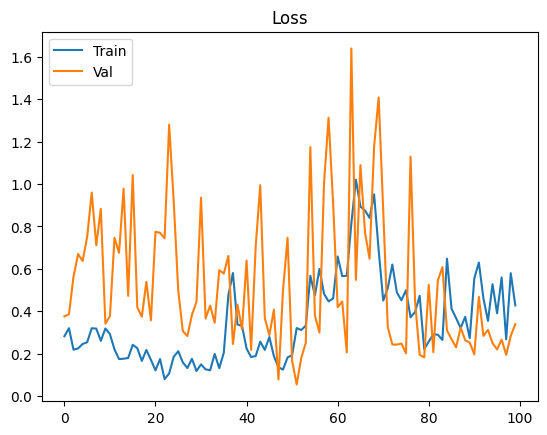

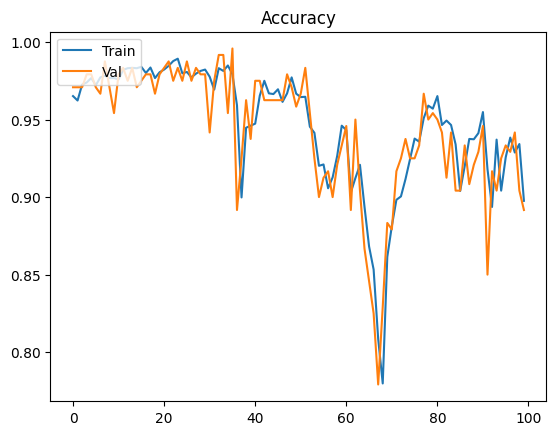

In [384]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

# Teste with 1 data

In [91]:
audio, sr = librosa.load("./dataset/teste/35f20a45f9b7830aca1982c09078edd477a57a8e6909f5c28c8f1e977c800fa85b5f2be61c80851eabd76fca82094308fcbb5eccc48aa87e9858017349767c60.mp3")
features = extract_features(audio, 0)
features = features[1:]

scaled_features = scaler.transform([features])
prediction = model.predict(scaled_features)
prediction


client id: 0
1/1 [==============================] - 0s 20ms/step


array([[6.1233353e-05, 3.1745166e-08, 2.2381061e-08, 2.6398406e-12,
        7.2194460e-08, 6.1986132e-12, 1.1949805e-07, 3.3740546e-10,
        1.3136778e-05, 4.1263329e-06, 1.1781894e-04, 1.7622747e-07,
        9.9896526e-01, 1.5239605e-08, 1.4687448e-10, 5.7048331e-09,
        3.8062134e-14, 2.8653835e-08, 4.5171222e-09, 8.1828812e-06,
        6.6340845e-06, 2.1446304e-10, 2.3701050e-12, 1.8808245e-12,
        1.7501243e-08, 2.7323447e-05, 1.9604973e-13, 1.3237342e-08,
        3.3150942e-13, 2.4584018e-08, 4.3731902e-08, 1.0562153e-11,
        1.8355189e-07, 6.1816041e-05, 5.2631313e-09, 3.7066032e-12,
        4.8699671e-06, 4.2319321e-06, 5.6082012e-08, 7.2469364e-04,
        4.7189318e-12, 2.5251753e-14, 1.6069160e-10, 1.9748942e-13,
        2.6911134e-10]], dtype=float32)

In [102]:
top_n_index = np.argsort(prediction[0])
prediction_percentages = [
    prediction[0][idx] * 100 for idx in top_n_index
]


len(prediction_percentages)

45